# How to compare two distributions

date: 2022-05-05
tags: probability, python, scipy
description: A comparison of common methods to compare two probability distributions in Python
draft: false
<!--eofm-->

The world is full of distributions - people's height, incomes, exam results, average temperatures, heights of trees, sizes of microplastic particles in the environment. It stands to reason that there will be times when we need to compare these distributions to see how similar (or different) they are. For example, were summer temperatures similar this year to last year? Do two groups of people who buy different products make similar incomes? Do modelled size distributions of microplastics match what we expect from observations?

There are a whole host of statistical methods you can use to calculate this *similarity*, and the aim of this article is to show you how a few of the most common can be easily coded in Python. In doing so, we will start to explore some of the differences between the methods and why you might pick one over the other.

## The problem



Let's start with three arbitrary normal distributions to demonstrate this. We will use SciPy's `stats.norm.rvs` method to generate these distributions by randomly sampling based on specified mean and variance values - basically, this lets us mimic "real" data that follows the specified distributions.

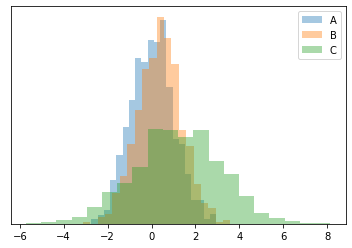

In [4]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Mean and variance of the distributions and sampling size
a_mean, a_var = 0.0, 1.0
b_mean, b_var = 0.42, 1.0
c_mean, c_var = 1.2, 2
size = 1000

# Create the distributions
data_a = stats.norm.rvs(a_mean, a_var, size)
data_b = stats.norm.rvs(b_mean, b_var, size)
data_c = stats.norm.rvs(c_mean, c_var, size)

# Plot the distributions as histograms to see what they
# look like compared to each other
plt.hist(data_a, bins=20, density=True, alpha=0.4, label='A')
plt.hist(data_b, bins=20, density=True, alpha=0.4, label='B')
plt.hist(data_c, bins=20, density=True, alpha=0.4, label='C')
plt.legend()
plt.yticks([])
plt.show()

## Method 0: Comparing the means

Perhaps it is stating the obvious, but if you expect all of the other [moments of your distributions](https://en.wikipedia.org/wiki/Moment_(mathematics)) (variance, skew and kurotis) to be similar, then comparing the means is a simple but effective way to see how different they are.

If we take $A$ as the reference distribution, to which we want to compare how similar $B$ and $C$ are, then we can simply calculate the difference between the means of $B$ or $C$ and $A$:

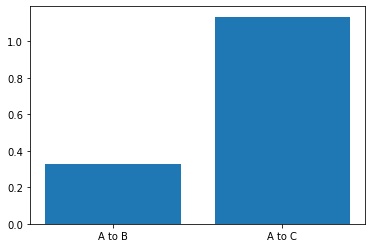

In [5]:
plt.bar(['A to B', 'A to C'],
        [data_b.mean() - data_a.mean(), data_c.mean() - data_a.mean()])
plt.show()

The rather obvious conclusion here is that $B$ is *more similar* to $A$ than $C$. But, you will have noticed that the variance (width) of $C$ is significantly different $A$ and $B$, and perhaps this naïve method is not so sensible for our distributions.

## Method 1: Kolmogorov-Smirnov distance

Apart from comparing means, calculating the K-S distance $D_\text{KS}$ between distributions is perhaps the most common way of comparing distributions. $D_\text{KS}$ is zero when distributions are identical, and 1 when they are very different. In other words, the bigger $D_\text{KS}$, the more different the distributions.

The concept behind the K-S distance is simple to understand: When plotted as *empirical* cumulative probability distributions, it represents the biggest difference in probability between the two distributions. Calculating $D_\text{KS}$ in Python is made straightforward by SciPy, which provides a [`scipy.stats.kstest`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html) function that does the hard work. Let's calculate $D_\text{KS}$ between $A$ and $C$: 


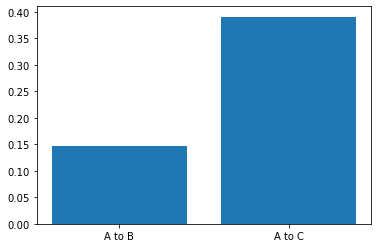

In [8]:
# Calculuate the K-S distance between A and B, and A and C
ks_a_b = stats.kstest(data_a, data_b)
ks_a_c = stats.kstest(data_a, data_c)

# Plot this to compare the distributions
plt.bar(['A to B', 'A to C'],
        [ks_a_b.statistic, ks_a_c.statistic])
plt.show()

{{< notice note >}}
Technically, we are performing a *two-sample* K-S test here, which is used to compare the underlying distributions of two independent samples. In contrast, the one-sample K-S test is used to compare the underlying distribution of a sample against a given distribution (such as the normal distribution). Internally, SciPy picks up that we have provided two independent samples and calls a separate `scipy.stats.ks_2samp` method. We could have called this method directly.
{{< /notice >}}

As we said, the K-S distance represents the maximum distance between the empirical cumulative distribution functions (ECDFs) of our data. We can generate and plot these ECDFs to make it easy to visualise what the K-S test is doing in practice. Let's do this to compare A and C:

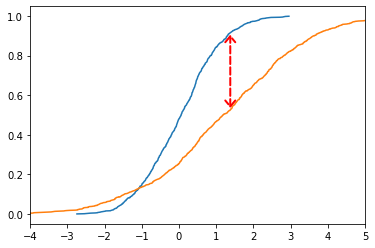

In [41]:
# We can plot ECDFs by sorting the data and plotting it on
# the x-axis against an equally spaced array from 0 to 1 on
# the y-axis, we can be generated by NumPy's linspace or
# arange functions
x_a = np.sort(data_a)
x_c = np.sort(data_c)
ecdf_a = np.linspace(0, 1, len(x_a), endpoint=False)
ecdf_c = np.linspace(0, 1, len(x_c), endpoint=False)

# Plot these ECDFs
plt.plot(x_a, ecdf_a)
plt.plot(x_c, ecdf_c)

# We need to figure out at which x value the biggest distance
# between the ECDFs is, in order to point this out on the graph.
# To do this, we first need to interpolate one of the ECDFs
ecdf_a_interp = np.interp(x_a, x_c, ecdf_a)
ix = np.argmax(np.abs(ecdf_a_interp - ecdf_c))

# Plot this as an arrow indicating the distance between the curves
plt.annotate('',
             xy=(x_a[ix], ecdf_a[ix]),
             xytext=(x_a[ix], ecdf_a[ix] - ks_a_c.statistic),
             arrowprops={'arrowstyle': '<->, head_width=0.5, head_length=0.6',
                         'linestyle': 'dashed', 'color': 'r', 'linewidth': 2})
plt.xlim([-4,5])
plt.show()